# `XTBTSScreener.jl` - Screening Likely Transition States with Julia and Machine Learning
This Jupyter notebook demonstrates the use of machine learning to predict if a partially-optimized initialization of a transition state, used in the study of chemical kinetics to predict rate constants, is _"likely to converge"_  or not after further simulation with expensive Density Functional Theory simulations.

It includes a step-by-step breakdown of loading the data, training the model, and evaluating the performance.
This notebook draws heavily from the Lux LSTM example [found here](https://lux.csail.mit.edu/stable/examples/generated/beginner/SimpleRNN/main/).

_Developed April 2023 by Jackson Burns for the Final Project in MIT 18.337: Parallel Computing and Scientific Machine Learning_

## Load the Data
The input data is saved in a CSV file, which was exported from a large SQL database of simulation results.
We can load it using `CSV.jl` and then partition the data into training and testing sets using `MLUtils.jl`.

At this moment in time the dataset is highly _unbalanced_ due to limitations in post-processing speed of simulations hindering retrieval of failed examples.
To reduce the impact of this phenomemon on the study, we will downsample the data to a 50:50 split of failed and converged samples.

In [1]:
using MLUtils, CSV

In [2]:
csv_reader = CSV.File("data/roo_co2_full_data_augmented_expanded.csv")
n_samples = 20501
# keep track of number of failed and converged to balance the dataset
number_converged = 0
number_failed = 0
# iterate through the entire dataset
for row in csv_reader[1:n_samples]
    # check the label
    if parse(Bool, "$(row.converged)")
        number_converged += 1
    else
        number_failed += 1
    end
end
smaller_label = minimum([number_converged, number_failed])
println(
    "Failed: $number_failed\n" *
    "Converged: $number_converged\n" *
    "Keep: $smaller_label",
)


Failed: 3274
Converged: 17227
Keep: 3274


Each row in the CSV will have the a matrix of spatial coordinates for the molecule and the Gibbs free energy, $E_{0}+ZPE$(sum of electronic total energy and zero point energy), and number of simulation steps for each of the three substeps in the optimization. Initial modeling results using only the coordinate arrays were unsuccessful, with models never seeing improvement in accuracy beyond randomly guessing. These augmented descriptors have shown to improve model performance over that baseline.

Each sample in the system represents a different chemical reaction and it can therefore have a different number of atoms.
The most that any molecule has will not exceed 55, so to leave room for growth and other descriptors we will zero pad each sample to a uniform length.

The exact mechanisms by which this function work are described in the inline comments, but just know that it involves a lot of string to float casting.

In [3]:
function get_dataloaders(smaller_label)
    csv_reader = CSV.File("data/roo_co2_full_data_augmented_expanded.csv")
    n_samples = 20501
    x_data = Array{Float32}(undef, 60, 6, smaller_label * 2)
    labels = Float32[]
    iter = 1
    println("Progress:")

    # keep track of number of failed to balance the dataset
    number_converged = 0
    number_failed = 0

    for row in csv_reader[1:n_samples]
        # print some updates as we go
        if mod(iter, div(n_samples, 10)) == 0
            println(" - row $iter of $smaller_label")
            flush(stdout)
        end

        # get if it converged or not, add alternating samples
        if parse(Bool, "$(row.converged)")
            if number_converged < number_failed
                push!(labels, 1.0f0)
                number_converged += 1
            else
                continue
            end
        else
            push!(labels, 0.0f0)
            number_failed += 1
        end

        # array for descriptors for this transition state
        m = Array{Float32}(undef, 60, 6)

        # pull out the augmented descriptors
        split_gibbs = split("$(row.gibbs)")
        split_steps = split("$(row.steps)")
        split_e0_zpe = split("$(row.e0_zpe)")
        split_descriptors = [split_gibbs, split_steps, split_e0_zpe]
        for i in 1:3
            for j in 1:3
                temp = String(split_descriptors[i][j])
                temp = replace(temp, "]" => "")
                temp = replace(temp, "[" => "")
                temp = replace(temp, "," => "")
                m[i, j] = parse(Float32, temp)
            end
            m[i, 4] = Float32(0.0)
            m[i, 5] = Float32(0.0)
            m[i, 6] = Float32(0.0)
        end

        # get the final coordinates of the atoms
        split_array = split("$(row.std_xyz)")
        n_atoms = Int(length(split_array) / 6)
        row_counter = 4
        column_counter = 1
        for value in split_array
            temp = String(value)
            temp = replace(temp, "]" => "")
            temp = replace(temp, "[" => "")
            temp = replace(temp, "," => "")
            m[row_counter, column_counter] = parse(Float32, temp)
            column_counter += 1
            if column_counter > 6
                column_counter = 1
                row_counter += 1
            end
        end

        # zero-padding
        for i in n_atoms+1:60
            m[i, 1:6] = [0, 0, 0, 0, 0, 0]
        end
        x_data[1:60, 1:6, iter] = m
        iter += 1
    end
    remainingsamples = length(labels)
    println("downsampled to $remainingsamples samples, $number_converged converged $number_failed failed")
    println("...loading done, partitioning data.")
    (x_train, y_train), (x_val, y_val) = splitobs((x_data, labels); at=0.8, shuffle=true)
    return (DataLoader(collect.((x_train, y_train)); batchsize=2^6, shuffle=true),
        DataLoader(collect.((x_val, y_val)); batchsize=2^6, shuffle=false))
end


get_dataloaders (generic function with 1 method)

For ease of debugging and as a reference, the original tutorial dataloading function is included below.

In [4]:
function get_tutorial_dataloaders()
    dataset_size = 1000
    sequence_length = 50
    data = [MLUtils.Datasets.make_spiral(sequence_length) for _ in 1:dataset_size]
    # Get the labels
    labels = vcat(repeat([0.0f0], dataset_size ÷ 2), repeat([1.0f0], dataset_size ÷ 2))
    clockwise_spirals = [reshape(d[1][:, 1:sequence_length], :, sequence_length, 1)
                         for d in data[1:(dataset_size÷2)]]
    anticlockwise_spirals = [reshape(d[1][:, (sequence_length+1):end], :, sequence_length,
        1) for d in data[((dataset_size÷2)+1):end]]
    x_data = Float32.(cat(clockwise_spirals..., anticlockwise_spirals...; dims=3))
    # Split the dataset
    (x_train, y_train), (x_val, y_val) = splitobs((x_data, labels); at=0.8, shuffle=true)
    return (DataLoader(collect.((x_train, y_train)); batchsize=128, shuffle=true),
        DataLoader(collect.((x_val, y_val)); batchsize=128, shuffle=false))
end


get_tutorial_dataloaders (generic function with 1 method)

## Configure the Neural Network
Following from the tutorial in the [Lux documentation](https://lux.csail.mit.edu/stable/examples/generated/beginner/SimpleRNN/main/) we write a series of functions that will create our NN.

In [5]:
using Lux, Random, Optimisers, Zygote, NNlib, Statistics

We seed the random number generator for consistent results.

In [6]:
rng = Random.default_rng()
Random.seed!(rng, 42)

TaskLocalRNG()

Define a new `struct` that extends the `Lux` `Container` type and holds the LSTM model and the classifier.

In [7]:
struct StateClassifier{L,C} <:
       Lux.AbstractExplicitContainerLayer{(:lstm_cell, :classifier)}
    lstm_cell::L
    classifier::C
end


In [8]:
function StateClassifier(in_dims, hidden_dims, out_dims)
    return StateClassifier(LSTMCell(in_dims => hidden_dims),
        Dense(hidden_dims => out_dims, sigmoid))
end


StateClassifier

In [9]:
function (s::StateClassifier)(x::AbstractArray{T,3}, ps::NamedTuple,
    st::NamedTuple) where {T}
    x_init, x_rest = Iterators.peel(eachslice(x; dims=2))
    (y, carry), st_lstm = s.lstm_cell(x_init, ps.lstm_cell, st.lstm_cell)
    for x in x_rest
        (y, carry), st_lstm = s.lstm_cell((x, carry), ps.lstm_cell, st_lstm)
    end
    y, st_classifier = s.classifier(y, ps.classifier, st.classifier)
    st = merge(st, (classifier=st_classifier, lstm_cell=st_lstm))
    return vec(y), st
end


Define the loss function, using binarycrossentropy for simplicity.

In [10]:
function xlogy(x, y)
    result = x * log(y)
    return ifelse(iszero(x), zero(result), result)
end

function binarycrossentropy(y_pred, y_true)
    y_pred = y_pred .+ eps(eltype(y_pred))
    return mean(@. -xlogy(y_true, y_pred) - xlogy(1 - y_true, 1 - y_pred))
end

function compute_loss(x, y, model, ps, st)
    y_pred, st = model(x, ps, st)
    return binarycrossentropy(y_pred, y), y_pred, st
end

matches(y_pred, y_true) = sum((y_pred .> 0.5) .== y_true)
accuracy(y_pred, y_true) = matches(y_pred, y_true) / length(y_pred)


accuracy (generic function with 1 method)

In [11]:
function create_optimiser(ps)
    opt = Optimisers.ADAM(0.0001f0)
    return Optimisers.setup(opt, ps)
end


create_optimiser (generic function with 1 method)

## Train the NN
Now with all of the boilerplate work out of the way, the NN can actually be trained!

From extensive debugging and iteration, it was determined that a _very_ low learning rate was critical for the successful operation of the NN. The number of epochs is set to 55, which is the point at which the change in the loss substantially decreases and the model begins to overfit. The ideal batch size was determined to be 2^6, and substantially higher or lower sizes would cause parabolic loss curves or numerical instability (which can be partially blamed on the loss function).

Begin by loading the data from the file and partition it:

In [12]:
(train_loader, val_loader) = get_dataloaders(smaller_label)

Progress:
 - row 2050 of 3274
 - row 4100 of 3274
 - row 6150 of 3274
downsampled to 6548 samples, 3274 converged 3274 failed
...loading done, partitioning data.


(DataLoader(::Tuple{Array{Float32, 3}, Vector{Float32}}, shuffle=true, batchsize=64), DataLoader(::Tuple{Array{Float32, 3}, Vector{Float32}}, batchsize=64))

Initialize the model and the optimizer (using ADAM):

In [13]:
model = StateClassifier(60, 6, 1)
rng = Random.default_rng()
Random.seed!(rng, 0)
ps, st = Lux.setup(rng, model)
opt_state = create_optimiser(ps)

(lstm_cell = (weight_i = Leaf(Adam{Float32}(0.0001, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), weight_h = Leaf(Adam{Float32}(0.0001, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float32}(0.0001, (0.9, 0.999), 1.19209f-7), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999)))), classifier = (weight = Leaf(Adam{Float32}(0.0001, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float32}(0.0001, (0.9, 0.999), 1.19209f-7), (Float32[0.0;;], Float32[0.0;;], (0.9, 0.999)))))

And finally, train the model printing the occassional update.

In [14]:
loss_vector = Float64[]
accuracy_vector = Float64[]
for epoch in 1:55
    # Train the model
    epoch_loss = Float64[]
    for (x, y) in train_loader
        (loss, y_pred, st), back = pullback(p -> compute_loss(x, y, model, p, st), ps)
        gs = back((one(loss), nothing, nothing))[1]
        opt_state, ps = Optimisers.update(opt_state, ps, gs)
        push!(epoch_loss, loss)
    end
    avg_loss = mean(epoch_loss)
    push!(loss_vector, avg_loss)

    # Validate the model
    epoch_accuracy = Float64[]
    st_ = Lux.testmode(st)
    for (x, y) in val_loader
        (loss, y_pred, st_) = compute_loss(x, y, model, ps, st_)
        acc = accuracy(y_pred, y)
        push!(epoch_accuracy, acc)
    end
    avg_accuracy = mean(epoch_accuracy)
    if epoch == 1 || mod(epoch, 5) == 0
        println("Epoch # $epoch:\n - loss of $avg_loss")
        println(" - accuracy of $avg_accuracy")
        flush(stdout)
    end
    push!(accuracy_vector, avg_accuracy)
end


Epoch # 1:
 - loss of 0.7282473619391279
 - accuracy of 0.5146825396825397
Epoch # 5:
 - loss of 0.7089660269458119
 - accuracy of 0.5236111111111111
Epoch # 10:
 - loss of 0.6943259777092352
 - accuracy of 0.5287202380952382
Epoch # 15:
 - loss of 0.686766859961719
 - accuracy of 0.5387896825396825
Epoch # 20:
 - loss of 0.6815697768839394
 - accuracy of 0.5472718253968254
Epoch # 25:
 - loss of 0.6774497729976002
 - accuracy of 0.5570436507936508
Epoch # 30:
 - loss of 0.6739311807039308
 - accuracy of 0.5617063492063492
Epoch # 35:
 - loss of 0.6705420882236667
 - accuracy of 0.5556547619047618
Epoch # 40:
 - loss of 0.6674438722249938
 - accuracy of 0.5660714285714286
Epoch # 45:
 - loss of 0.6641433820491884
 - accuracy of 0.5712797619047618
Epoch # 50:
 - loss of 0.661274130751447
 - accuracy of 0.5734126984126984
Epoch # 55:
 - loss of 0.6587260307335272
 - accuracy of 0.5696924603174602


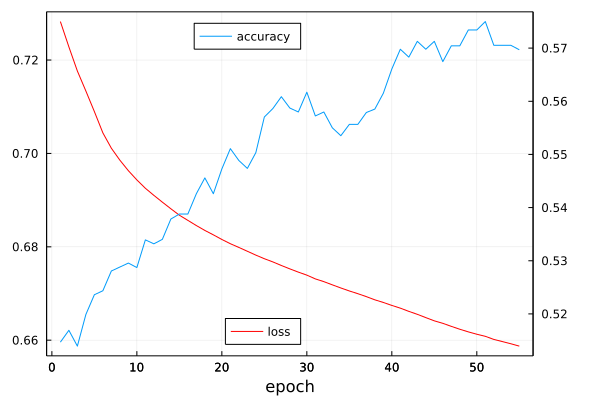

In [15]:
using Plots
plot(loss_vector, label="loss", legend=:bottom, color=:red, rightmargin=1.5Plots.cm, bottommargin=0.5Plots.cm, box=:on, fmt=:png)
plot!(twinx(), accuracy_vector, label="accuracy", legend=:top, xlabel="epoch", rightmargin=1.5Plots.cm, bottommargin=0.5Plots.cm, box=:on)


While this final accuracy is not outstanding, it is worthwhile for this use case since every successful prediction could save potentially _weeks_ of time.
If taken more as a proof of concept, providing a model with only the molecular coordinates and then augmenting the data with electronic descriptors retrived from the same calculations was able to dramatically improve the results.
In the future, more descriptors could be added to further increase the performance, or alternative network architectures could be explored.

In [16]:
using Dates
timestamp = now()
savefig("results/result-$timestamp.png")